### Предсказание цены на Iphone7 по содержимому описания обьявления о продаже на сайте avito.ru

# Ultra PRO задание
## Найдите любую базу, подходящую для регрессии:
###Спарсите данные
 - Разделите данные на обучающую и проверочную выборки
 - Напишите сеть для регрессии
 - Сделайте визуализацию результата
 - Напишите ваши результаты и выводы


In [0]:
# Подключение библиотек
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import re
import time
import random

from keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from keras.models import Sequential, Model
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import LambdaCallback
import keras
import keras.backend as K

from IPython.display import clear_output

from google.colab import files

# Чтение данных

In [2]:
# Монтируем Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [16]:
# Читаем данные
df = pd.read_csv('/content/drive/My Drive/Базы/avito.csv') #загружаем данные в data frame
df.head(5)    #взглянем на содержимое

,town,text,price
0,"Москва, Шарикоподшипниковская ул., 13с3",Айфон7 iPhone7plus оригинал!не после ремонта! ...,8800
1,"Москва, Алтуфьевское ш.",Только обмен на iPhone X телефон с коробкой Те...,10000
2,Москва,Доброго времени суток 😁Цена без торга 😑iPhone ...,12500
3,"Москва, ул. Земляной Вал","Продаётся IPhone 7 Rose Gold 128GB, в илеально...",12000
4,"Москва, ул. Новый Арбат, 2","Полностью рабочий, оригинал, не реф, ничего н...",19500


In [17]:
# Взглянем на размер выборки с обьявлениями
print(df.shape)

(6382, 3)


# Парсинг Базы

In [18]:
# Удаляем строки с заголовками из строк базы
df_clean = df[df.town != 'town']
df_clean.columns = ['town', 'text', 'price']
df_clean = df_clean.reset_index(drop=True)
print(df_clean.shape)

(6210, 3)


In [0]:
# Оставляем от названия города только первое слово
def get_clean_town(full_town):
  clean_town = full_town.split(',')[0]
  return clean_town

df_clean['town'] = df_clean['town'].apply(get_clean_town)

In [0]:
# Чистим текст обьявления от пробелов и переносов строк
def get_clean_text(derty_text):
  clean_text = derty_text.replace("\xa0","")
  clean_text = clean_text.replace("\n"," ")
  clean_text = clean_text.replace(","," ")
  clean_text = clean_text.replace("😁"," ")
  clean_text = clean_text.replace("😑"," ")
  clean_text = clean_text.replace("🔥"," ")
  clean_text = clean_text.replace("🍏"," ")
  clean_text = clean_text.replace("!"," ")
  clean_text = clean_text.replace("."," ")
  clean_text = clean_text.replace("✔️"," ")
  clean_text = clean_text.replace("■"," ")
  clean_text = clean_text.replace("●"," ")

  return clean_text

df_clean['text'] = df_clean['text'].apply(get_clean_text)

In [21]:
df_clean.head(5)

,town,text,price
0,Москва,Айфон7 iPhone7plus оригинал не после ремонта ...,8800
1,Москва,Только обмен на iPhone X телефон с коробкой Те...,10000
2,Москва,Доброго времени суток Цена без торга iPhone ...,12500
3,Москва,Продаётся IPhone 7 Rose Gold 128GB в илеально...,12000
4,Москва,Полностью рабочий оригинал не реф ничего н...,19500


In [22]:
# Посмотрим на количество уникальных городов
df_clean.groupby(['town'])['town'].count()

town
Арбатско-Покровская линия                            2
Дербент                                              2
Курское направление Московской железной дороги       1
Ленинградская область                                3
Маршала Жукова пр-кт                                 1
Москва                                            4131
Московская область                                  12
Рижское направление Московской железной дороги       3
Санкт-Петербург                                   2052
метро                                                2
ул Вишнёвая                                          1
Name: town, dtype: int64

In [23]:
# Оставим только наиболее значимые города по количеству обьявлений
df_clean = df_clean[(df_clean.town == 'Москва') | (df_clean.town == 'Санкт-Петербург')]
print(df_clean.shape)
# Посмотрим на количество уникальных городов
df_clean.groupby(['town'])['town'].count()

(6183, 3)


town
Москва             4131
Санкт-Петербург    2052
Name: town, dtype: int64

In [24]:
#################
#Задаем параметры для обработки данных
#################
texts_clean = df_clean['text'].values              #извлекаем данные всех текстов из столбца text
classes_clean = list(df_clean['town'].values)  #извлекаем соответствующие им значения классов(лейблов) столбца text
maxWordsCount = 15000                  #зададим макс.кол-во слов/индексов, учитываемое при обучении текстов

print(df_clean['town'].unique())         #выводим все уникальные значения классов
nClasses = df_clean['town'].nunique()  #задаём количество классов, обращаясь к столбцу category и оставляя уникальные значения
print(nClasses) #взглянем на количество классов
print(texts_clean.shape)

['Москва' 'Санкт-Петербург']
2
(6183,)


In [25]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(texts_clean)           #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 14553


In [26]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
texts_in_WordIndexes = tokenizer.texts_to_sequences(texts_clean) #обучающие тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", texts_clean[5] [:89])
print("Он же в виде последовательности индексов: ", texts_in_WordIndexes[5][:20])
print()

print(len(texts_in_WordIndexes))

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Телефон на 32 gb  Состояние хорошее  Без комплекта  По остальному пишите отвечу на любые 
Он же в виде последовательности индексов:  [12, 6, 37, 26, 22, 223, 14, 562, 9, 3445, 102, 529, 6, 40, 204]

6183


In [27]:
#################
#преобразовываем города в вектора
#################
encoder = LabelEncoder() #вызываем метод кодирования тестовых лейблов из библиотеки sklearn
encoder.fit(classes_clean)     #подгружаем в него категории из нашей базы
classesEncoded = encoder.transform(classes_clean)           #кодируем категории
xTowns = utils.to_categorical(classesEncoded, nClasses) #и выводим каждый лейбл в виде вектора длиной 22, с 1кой в позиции соответсвующего класса и нулями
print(xTowns.shape)  #взглянем на форму лейблов категорий
#print(xTowns[0])     #и отдельно на первую строку

(6183, 2)


In [28]:
# для текстов в собщениях формируем матрицу индексов по принципу Bag of Words
xTexts = tokenizer.texts_to_matrix(texts_clean) #каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount отметилось в нем единичкой 
print(xTexts.shape)  #взглянем на форму текстов
print(xTexts[0, :20])#и отдельно на фрагмент начала вектора

(6183, 15000)
[0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]


In [78]:
# Получаем значения Y для регрессии
yPrices = df_clean['price'].values 
print(yPrices.shape)
print('Средняя цена -', round(yPrices.astype(int).mean(),2))

(6183,)
Средняя цена - 14981.2


In [32]:
# Создаем маски для тренировочной и валидационной выборок
test_size=0.2
val_mask = []

full_mask = set([x for x in range(0,xTexts.shape[0])])

while len(val_mask) < xTexts.shape[0]*test_size:
  cur_rnd = random.randint(0, xTexts.shape[0])
  if not (cur_rnd in val_mask):
    val_mask.append(cur_rnd)


train_mask = list(full_mask - set(val_mask))
print('Тренировочная  выборка - ',len(train_mask))
print('Валидационнная выборка - ',len(val_mask))
print(len(train_mask)+len(val_mask))

Тренировочная  выборка -  4946
Валидационнная выборка -  1237
6183


## Составная нейронка на двух типах данных одновременно

In [0]:
input1 = Input((xTowns.shape[1],))
input2 = Input((xTexts.shape[1],))

x1 = Dense(1, activation="relu")(input1)  # Создаем ветку х1

x2 = Dense(100, activation ="selu")(input2) # Создаем ветку х2
x2 = Dense(200, activation ="selu")(x2)
x2 = Dense(300, activation ="selu")(x2)

x = concatenate([x1, x2]) # Объединяем обе ветки

x = Dense(200, activation='linear')(x)
x = Dropout(0.25)(x)
out = Dense(1, activation='linear')(x) # Финальный нейрон, делает регрессию

modelS = Model((input1, input2), out) # В Model загружаем стартовые и последнюю точки 

Train on 4946 samples, validate on 1237 samples
Epoch 1/60
4946/4946 [==============================] - 4s 882us/step - loss: 258779041.1840 - mean_absolute_error: 14959.4648 - val_loss: 242286818.5222 - val_mean_absolute_error: 14810.7829
Epoch 2/60
4946/4946 [==============================] - 3s 580us/step - loss: 243853309.6385 - mean_absolute_error: 14453.3265 - val_loss: 208574141.9305 - val_mean_absolute_error: 13638.3969
Epoch 3/60
4946/4946 [==============================] - 3s 578us/step - loss: 174596066.6138 - mean_absolute_error: 11738.4558 - val_loss: 103023675.6411 - val_mean_absolute_error: 8862.0107
Epoch 4/60
4946/4946 [==============================] - 3s 574us/step - loss: 75204641.2584 - mean_absolute_error: 6370.8291 - val_loss: 42947573.6297 - val_mean_absolute_error: 5019.5905
Epoch 5/60
4946/4946 [==============================] - 3s 568us/step - loss: 51076698.7756 - mean_absolute_error: 4711.4392 - val_loss: 35583907.2999 - val_mean_absolute_error: 4496.9798
E

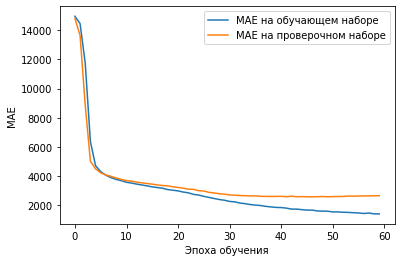

Результат обучения нейросети
MAE =  1404.0313



In [59]:
# Обучение сети
epochs=60

modelS.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
my_callback = MyCallback()
history = modelS.fit([xTowns[train_mask], xTexts[train_mask]], 
                    yPrices[train_mask], 
                    epochs=epochs,
                    batch_size=64, 
                    validation_data=([xTowns[val_mask], xTexts[val_mask]], 
                    yPrices[val_mask]), 
                    verbose=1)

plt.plot(history.history['mean_absolute_error'], 
         label='МАЕ на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='МАЕ на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('МАЕ')
plt.legend()
plt.show()

mae = history.history['mean_absolute_error'][-1]
print('='*100)
print('Результат обучения нейросети')
print('MAE = ', np.round(mae,4))
print('='*100)
print()

Train on 4946 samples, validate on 1237 samples
Epoch 1/3
4946/4946 [==============================] - 4s 870us/step - loss: 13588220.9060 - mean_absolute_error: 1363.5139 - val_loss: 15387386.6544 - val_mean_absolute_error: 2644.0396
Epoch 2/3
4946/4946 [==============================] - 3s 569us/step - loss: 13471152.6950 - mean_absolute_error: 1364.1352 - val_loss: 15413927.5016 - val_mean_absolute_error: 2646.9363
Epoch 3/3
4946/4946 [==============================] - 3s 570us/step - loss: 13336552.3867 - mean_absolute_error: 1370.7064 - val_loss: 15432680.4834 - val_mean_absolute_error: 2648.7206


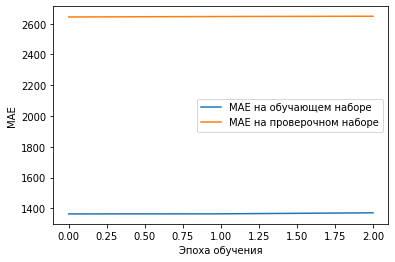

Результат обучения нейросети
MAE =  1370.7064



In [60]:
# Добучение сети
epochs=3

modelS.compile(optimizer=Adam(lr=1e-5), loss='mse', metrics=['mae'])
my_callback = MyCallback()
history = modelS.fit([xTowns[train_mask], xTexts[train_mask]], 
                    yPrices[train_mask], 
                    epochs=epochs,
                    batch_size=64, 
                    validation_data=([xTowns[val_mask], xTexts[val_mask]], 
                    yPrices[val_mask]), 
                    verbose=1)

plt.plot(history.history['mean_absolute_error'], 
         label='МАЕ на обучающем наборе')
plt.plot(history.history['val_mean_absolute_error'], 
         label='МАЕ на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('МАЕ')
plt.legend()
plt.show()

mae = history.history['mean_absolute_error'][-1]
print('='*100)
print('Результат обучения нейросети')
print('MAE = ', np.round(mae,4))
print('='*100)
print()

# My Keras Callbacks

In [0]:
# New
class MyCallback(keras.callbacks.Callback):
    def __init__(self):
        self.time_start = 0      # Время начала обучения
        self.time_sum   = 0      # Общее время обучения
        self.list_time = []      # Список времен по эпохам
        self.list_train_mae = [] # Список МАЕ по тренировочной выбоке
        self.list_val_mae = []   # Список МАЕ по валидационной выбоке
        self.list_lr = []        # Список Learning Rate

        # Переменные для хранения предсказаний модели для выборок
        #self.pred_val   = 0

        self.time_start = time.time()
        self.list_time.append(self.time_start) # Время старта начала обучения

    # Функция возвращает время в виде строки - часы, минуты, секунды
    def get_str_time(self, dig_time):
        if dig_time <= 60:
          return str(round(dig_time,2)) + ' сек.'
        if dig_time <= 3600:
          minute = dig_time//60
          secund = dig_time - minute*60
          return str(minute) + ' мин. ' + str(round(secund,2)) + ' сек. '
        if dig_time > 3600:
          hour   = dig_time//3600
          minute = (dig_time - hour*3600)//60
          secund = dig_time - hour*3600 - minute*60
          return str(hour) + ' час. ' + str(minute) + ' мин. ' + str(round(secund,2)) + ' сек. '

    # Функция расчета статистик по времени обучения
    def print_time(self, epoch, logs):
        print('Текущая эпоха         = ', epoch+1)
        print('Время обучения на текущей эпохе  = ', self.get_str_time(self.list_time[-1] - self.list_time[-2]))
        print('Среднее время обучения на эпоху   = ', self.get_str_time((self.list_time[-1] - self.list_time[0])/ len(self.list_time)))
        print('Время обучения с начала обучения  = ', self.get_str_time(self.list_time[-1] - self.list_time[0]))
        print()
        print('Осталось эпох                  = ', epochs - epoch - 1)
        time_cont = (self.list_time[-1] - self.list_time[0]) / len(self.list_time) * (epochs - epoch)
        print('Осталось времени до конца обучения = ', self.get_str_time(time_cont))
        print('-'*80)
        print()

    # Функция для вычисления усредненной ошибки и записи ее в список
    def print_mae(self, epoch, logs):        
        # Тренировочная выборка        
        print("Эпоха", epoch+1, "модуль ошибки на тренировочных данных", round(self.list_train_mae[-1], 3))  #Выводим усреднённую ошибку 
        # Валидационная выборка
        print("Эпоха", epoch+1, "модуль ошибки на валидационных данных", round(self.list_val_mae[-1], 3))  #Выводим усреднённую ошибку 

    # Функция отрисовки графика усредненной ошибки по эпохам
    def plot_mae(self):
        plt.plot(self.list_train_mae, 
                label='Средняя абсолютная ошибка на обучающем наборе')
        plt.plot(self.list_val_mae, 
                label='Средняя абсолютная ошибка на проверочном наборе')
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя абсолютная ошибка')
        plt.legend()
        plt.show()

    # Функция отрисовки графика предсказаний на валидационных данны может показать перекос, если есть
    def plot_scr_val(self):
        self.pred_val = self.model.predict([self.validation_data[0],self.validation_data[1]]).flatten()
        plt.scatter(self.validation_data[2].flatten(), self.pred_val) 
        plt.xlabel('Правильные значение')
        plt.ylabel('Предсказания')
        plt.axis('equal')
        plt.xlim(plt.xlim())
        plt.ylim(plt.ylim())
        plt.plot([-100, 100], [-100, 100])
        plt.show()

    # Функция отрисовки гистограммы модуля ошибки на валидационных данных
    def plot_hist_val(self):
        error = (self.pred_val - self.validation_data[3].flatten())
        #Построение гистограммы
        plt.hist(abs(error), bins = 100)
        plt.xlabel("Значение ошибки, тыс.руб.")
        plt.ylabel("Количество")
        plt.show()

    # Функция записи в файл лучшего результата по МАЕ
    def save_best_mae(self):
        if (len(self.list_val_mae[:-1]) > 1) and (self.list_val_mae[-1] < np.array(self.list_val_mae[:-1]).min()):
          self.model.save('/content/drive/My Drive/UAI/Neuron Networks/Занятие №6 Регрессия/best_mae.h5')  # creates a HDF5 file 'my_model.h5'
          print('Сохранена модель с МАЕ =', self.list_val_mae[-1])

    # Функция для изменения шага обучения по МАЕ
    def change_lerning_rate(self, epoch):
        print('Текущий Learning Rate = ', K.get_value(self.model.optimizer.lr))
        
        # Плато и пилу будем искать на участке протяженностью num эпох
        num = 5     #  Количество эпох для анализа
        saw   = 0.05   #  Пила - МАЕ скачет больше чем на 5%
        plato = 0.001 #  Плато - МАЕ не меняется больше чем на 0.1% на протяжении num эпох
      
        if (len(self.list_train_mae) >= num) and(epoch % 5 == 0):
          # Анализ на есть ли плато
          razn = abs(self.list_train_mae[-1] - self.list_train_mae[-num])
          razn_per = razn/self.list_train_mae[-1]
          if razn_per < plato:       
            print('Нашли плато')
            # Увеличиваем Learning Rate в 2 раза
            lr_new = K.get_value(self.model.optimizer.lr) * 2
            # Проверяем верхнюю границу Learning Rate, что бы она не подымалась выше 1e-3 
            if lr_new > 1e-3:
              lr_new = 1e-3
              print('Достигнута верхняя граница lr, сохранен текущий lr = ', lr_new)
              return
            else:
              print('Увеличил lr в 2 раза, новый lr = ', lr_new)
              K.set_value(self.model.optimizer.lr, lr_new)
              return

          # Анализ есть ли пила - соседние показания скачут больше чем на saw процентов
          list_MAE = self.list_train_mae[-num:]
          for i in range(num-1):
            razn = abs(list_MAE[i] - list_MAE[i+1])
            razn_per = razn/list_MAE[i] 
            if razn_per > saw :
              print('Нашли пилу')
              # Уменьшаем Learning Rate в 2 раза
              lr_new = K.get_value(self.model.optimizer.lr) / 2
              # Проверяем нижнюю границу Learning Rate, что бы она не опускалась ниже 1e-7 
              if lr_new < 1e-7:
                lr_new = 1e-7
                print('Достигнута нижняя граница lr, сохранен текущий lr = ', lr_new)
                return
              else:
                print('Уменьшил lr в 2 раза, новый lr = ', lr_new)
                K.set_value(self.model.optimizer.lr, lr_new)
                return
    
    def on_train_begin(self, logs={}):
        self.losses = []
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_begin(self, epoch, logs={}):
        # Очистка экрана
        pass
        #print()
        #clear_output() # Очистка экрана

    def on_epoch_end(self, epoch, logs={}): 
        clear_output() # Очистка экрана
        # Записываем в списки значение МАЕ для тренировочной и валидационной выборок 
        self.list_train_mae.append(logs.get('mean_absolute_error')) # Список МАЕ по тренировочной выбоке
        self.list_val_mae.append(logs.get('val_mean_absolute_error'))   # Список МАЕ по валидационной выбоке  
        # Добавляем текущее время в список и печатаем статистику по времени
        self.list_time.append(time.time())
        self.print_time(epoch, logs)        
        # Печать тукущих МАЕ
        self.print_mae(epoch, logs)
        # Отрисовка МАЕ
        self.plot_mae()
        # Отрисовка скраттера
        self.plot_scr_val()
        # Отрисвка гистограммы ошибок
        self.plot_hist_val()
        # Запись наилучшего результата по МАЕ на валидации
        self.save_best_mae()
        # Изменение learning rate
        self.change_lerning_rate(epoch)
    
    def on_train_end(self, logs={}):
        print('Тренировка закончена')

Текущая эпоха         =  100
Время обучения на текущей эпохе  =  5.58 сек.
Среднее время обучения на эпоху   =  5.33 сек.
Время обучения с начала обучения  =  8.0 мин. 58.73 сек. 

Осталось эпох                  =  0
Осталось времени до конца обучения =  5.33 сек.
--------------------------------------------------------------------------------

Эпоха 100 модуль ошибки на тренировочных данных 1496.262
Эпоха 100 модуль ошибки на валидационных данных 2603.501


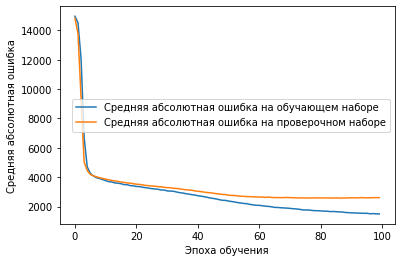

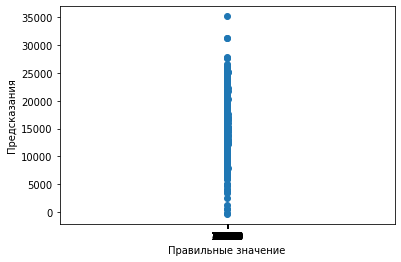

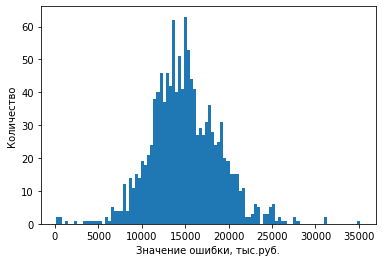

Текущий Learning Rate =  5e-05
Тренировка закончена


In [67]:
epochs=100

modelS.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['mae'])
my_callback = MyCallback()
history = modelS.fit([xTowns[train_mask], xTexts[train_mask]], 
                    yPrices[train_mask], 
                    epochs=epochs,
                    batch_size=64, 
                    validation_data=([xTowns[val_mask], xTexts[val_mask]], 
                    yPrices[val_mask]), 
                    verbose=0,
                    callbacks=[my_callback])

## Выводы:
### Для данной рабты были спарсены 6500 обьявлений о продаже IPhone 7 с сайта avito.ru
Из данных обьявлений были выделены города продаж, текст с описанием продаваемого телефона и его цена. Города продаж были уникально закодированы в OHE, текст обьявления переведен в формат bag of words. 
После этого, на этих данных обучили нейросеть - уметь предсказывать цену телефона IPhone 7 в зависимости от города где телефон продают и текста с описанием продаваемого телефона. Сеть обучилась на этих данных предсказывать стоимость телефона со средней точностью до 2600 руб. на валидационных данных и до 1400 руб. на тренировочных.

Т.к. Средняя цена IPhone 7 по обучающим данным равна 15000 руб, то при нашей средней ошибке на валидационных данных в 2600 руб., можно сказать, что исходя из города продажи и текста описания телефона мы сможем предсказать его цену с точностью 17%.